使用Python建立ARIMA模型，并就其实现过程进行逐步说明

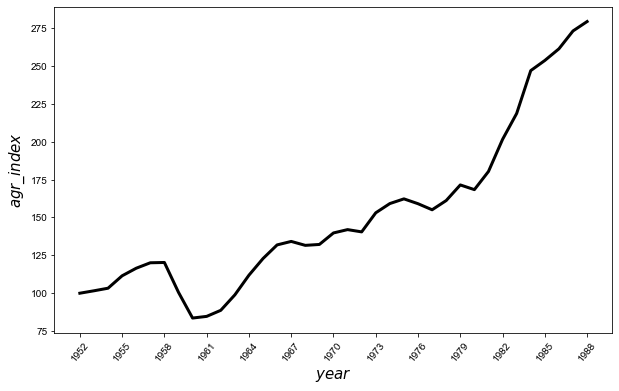

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
# 以下 font.family 设置仅适用于 Mac系统，其它系统请使用对应字体名称
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'

# 加载基础数据
ts_data = pd.read_csv("http://image.cador.cn/data/arg_index.csv")
rows = ts_data.shape[0]
plt.figure(figsize=(10,6))
plt.plot(range(rows),ts_data.agr_index,'-',c='black',linewidth=3)
plt.xticks(range(rows)[::3],ts_data.year[::3],rotation=50)
plt.xlabel("$year$",fontsize=15)
plt.ylabel("$agr\_index$",fontsize=15)
plt.show()

进一步，需要对数据进行差分运算，使差分后的数据变得平稳

In [2]:
# 此处预留10年的数据进行验证
test_data = ts_data[(rows - 10):rows]
train_data = ts_data[0:(rows - 10)]

# 进行d阶差分运算
d = 1
z = []
for t in range(d,train_data.shape[0]):
    tmp = 0
    for i in range(0,d+1):
        tmp = tmp + (-1)**i*(np.math.factorial(d)/(np.math.factorial(i)*np.math.factorial(d-i)))*train_data.iloc[t-i,1]
    z.append(tmp)

# 使用单位根检验差分后序列的平稳性
import statsmodels.tsa.stattools as stat
stat.adfuller(z, 1)

(-3.3156652637567237,
 0.01419259429184531,
 1,
 24,
 {'1%': -3.7377092158564813,
  '5%': -2.9922162731481485,
  '10%': -2.635746736111111},
 161.9148847383757)

从由于检验结果的P值为0.0142小于0.05，所以拒绝原假设，认为差分后的序列是平稳的。进一步编码对其进行Ljung_Box检验

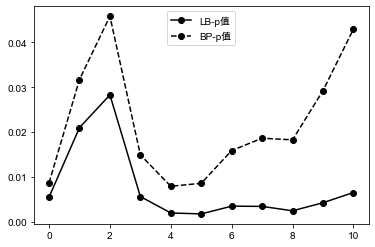

In [3]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
import warnings
warnings.filterwarnings("ignore")
plt.plot(lb_test(z,boxpierce=True)[1],'o-',c='black',label="LB-p值")
plt.plot(lb_test(z,boxpierce=True)[3],'o--',c='black',label="BP-p值")
plt.legend()
plt.show()

由于Ljung-Box检验的P值都小于0.05，所以差分后的序列不能视为白噪声。因此，经过1阶差分，我们得到的序列是一个平稳非白噪声的序列。

接着，需要对该模型定阶

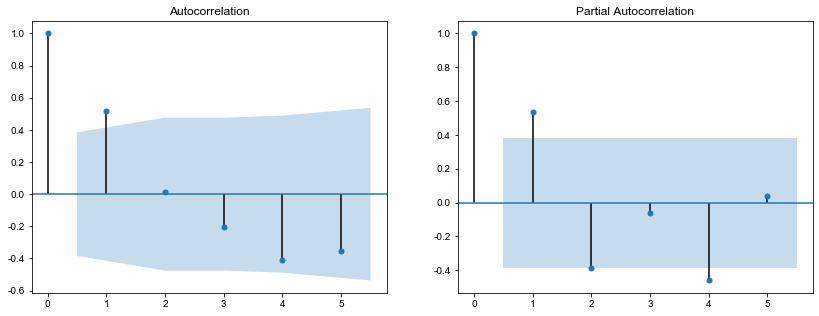

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['axes.unicode_minus']=False  
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,5))
ax0, ax1 = axes.flatten()
plot_acf(z, ax=ax0, lags=5, alpha=0.05)
plot_pacf(z, ax=ax1, lags=5, alpha=0.05)
plt.show()

基于该方法，对模型进行拟合

In [5]:
# 基于最小化残差平方和的假设，使用梯度下降法拟合未知参数
miu = np.mean(z)
miu

2.3538461538461535

In [6]:
theta1 = 0.5
alpha = 0.0001
epsilon_theta1 = 0
errorList = []
for k in range(60):
    epsilon = 0
    error = 0
    for i in range(len(z)):
        epsilon_theta1 = epsilon+theta1*epsilon_theta1
        theta1 = theta1-alpha*2*(z[i]-miu+theta1*epsilon)*epsilon_theta1
        epsilon = z[i]-miu+theta1*epsilon
        error = error+epsilon**2
    errorList.append(error)
    print("iter:",k," error:",error)
    # 当连续两次残差平方和的差小于1e-5时，退出循环
    if len(errorList) > 2 and np.abs(errorList[-2] - errorList[-1]) < 1e-5:
        break

iter: 0  error: 2158.5528412123554
iter: 1  error: 1629.117571439535
iter: 2  error: 1378.697932325996
iter: 3  error: 1235.2190474720771
iter: 4  error: 1142.2965898571713
iter: 5  error: 1076.8532240031996
iter: 6  error: 1027.8924012002753
iter: 7  error: 989.6669843636017
iter: 8  error: 959.0297556396869
iter: 9  error: 934.2431511645342
iter: 10  error: 914.3556848351807
iter: 11  error: 898.8045882009068
iter: 12  error: 887.1262330459601
iter: 13  error: 878.7756420117585
iter: 14  error: 873.0924002584927
iter: 15  error: 869.3887360432306
iter: 16  error: 867.059724076036
iter: 17  error: 865.6374177627687
iter: 18  error: 864.789223133888
iter: 19  error: 864.2924974052195
iter: 20  error: 864.0052902835599
iter: 21  error: 863.8406055985706
iter: 22  error: 863.7466612310309
iter: 23  error: 863.6932355186759
iter: 24  error: 863.6629072021001
iter: 25  error: 863.6457085003667
iter: 26  error: 863.6359611808334
iter: 27  error: 863.6304387805869
iter: 28  error: 863.627310

In [7]:
theta1

-0.7940837640329033

基于该模型，分析差分后序列对应的残差序列，检验是否为白噪声序列

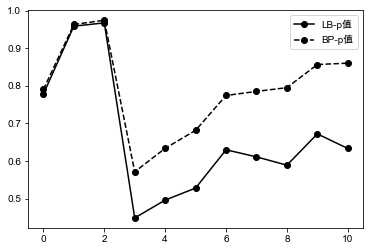

In [8]:
error = []
epsilon = 0
for i in range(len(z)):
    epsilon = z[i]-miu+theta1*epsilon
    error.append(epsilon)
    
# 使用Ljung-Box检验error序列是否为白噪声
plt.plot(lb_test(error,boxpierce=True)[1],'o-',c='black',label="LB-p值")
plt.plot(lb_test(error,boxpierce=True)[3],'o--',c='black',label="BP-p值")
plt.legend()
plt.show()

该模型可对未来1年的数据进行趋势预测，剩余年份只能等于序列均值了，同时绘制曲线与真实数据进行比较

In [9]:
# 基于该模型对差分后的序列进行预测
predX = miu+np.mean(error)-theta1*epsilon
predX

4.745789901194965

In [10]:
# 由于经过1阶差分的运算，所以此处需要进行差分的逆运算，以计算原始序列对应的预测值
org_predX=train_data.iloc[-1,1]+predX
org_predX

165.94578990119496

In [11]:
#对超过1期的预测值，统一为 predXt
predXt = org_predX+2.353846+1.7940838*np.mean(error)
predXt

168.3897028849476

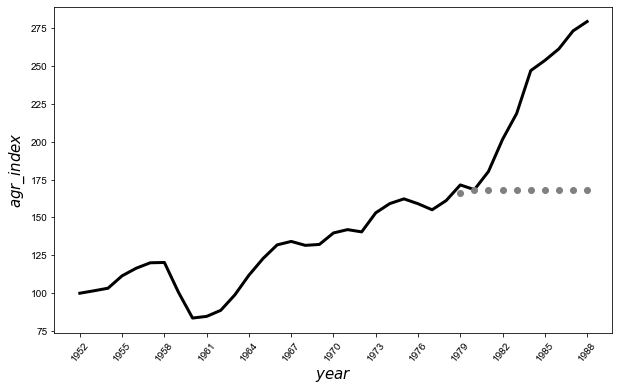

In [12]:
# 绘制出原始值和预测值
plt.figure(figsize=(10,6))
plt.plot(range(rows),ts_data.agr_index,'-',c='black',linewidth=3)
plt.plot(range(train_data.shape[0],ts_data.shape[0]),[org_predX]+[predXt]*9,'o',c='gray')
plt.xticks(range(rows)[::3],ts_data.year[::3],rotation=50)
plt.xlabel("$year$",fontsize=15)
plt.ylabel("$agr\_index$",fontsize=15)
plt.show()

对以上代码进行改进，使用最新的结果修正误差，以得到可靠的预测结果

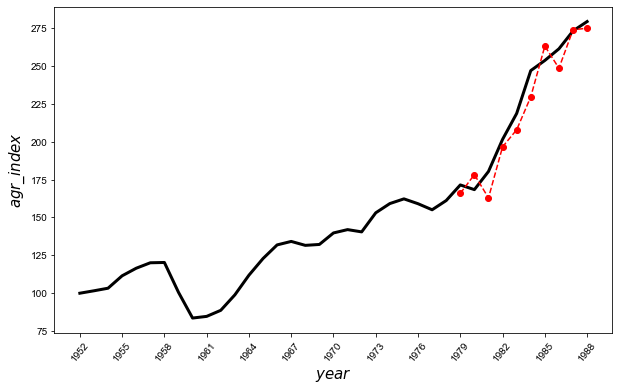

In [13]:
predX = []
for i in range(10):
    predval = miu + np.mean(error) - theta1*epsilon
    if i == 0:
        org_predX = train_data.iloc[-1,1] + predval
    else:
        org_predX = test_data.iloc[i-1,1] + predval
    predX.append(org_predX)
    epsilon = test_data.iloc[i,1] - org_predX

plt.figure(figsize=(10,6))
plt.plot(range(rows),ts_data.agr_index,'-',c='black',linewidth=3)
plt.plot(range(train_data.shape[0],ts_data.shape[0]),predX,'o--',c='red')
plt.xticks(range(rows)[::3],ts_data.year[::3],rotation=50)
plt.xlabel("$year$",fontsize=15)
plt.ylabel("$agr\_index$",fontsize=15)
plt.show()